In [22]:
import time
import os
from tqdm import tqdm

import pandas as pd
import numpy as np
import cv2
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


In [84]:
#from wordcloud import WordCloud
from collections import defaultdict
from collections import Counter

import itertools

import re

from wordcloud import WordCloud

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc("font",family='SimHei') # 中文字体
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [3]:
from torchvision import transforms

In [4]:
import xml.etree.ElementTree as ET

In [5]:
# 数据集文件夹路径
directory = '../data/NLMCXR/ecgen-radiology'
image_dir='../data/NLMCXR/NLMCXR_png/'

In [6]:
# extracting data from the xml documents
img = []
img_impression = []
img_finding = []
for filename in tqdm(os.listdir(directory)):
    if filename.endswith(".xml"):
        f = directory + '/' + filename
        tree = ET.parse(f)
        root = tree.getroot()
        for child in root:
            if child.tag == 'MedlineCitation':
                for attr in child:
                    if attr.tag == 'Article':
                        for i in attr:
                            if i.tag == 'Abstract':
                                for name in i:
                                    if name.get('Label') == 'FINDINGS':
                                        finding=name.text
                                        
        for p_image in root.findall('parentImage'):
            
            img.append(p_image.get('id'))
            img_finding.append(finding)

100%|████████████████████████████████████████████████████████████████████████████| 3955/3955 [00:02<00:00, 1863.39it/s]


In [7]:
dataset = pd.DataFrame()
dataset['Image_path'] = img
dataset['Finding'] = img_finding
dataset.head(10)

,Image_path,Finding
0,CXR1_1_IM-0001-3001,The cardiac silhouette and mediastinum size ar...
1,CXR1_1_IM-0001-4001,The cardiac silhouette and mediastinum size ar...
2,CXR10_IM-0002-1001,The cardiomediastinal silhouette is within nor...
3,CXR10_IM-0002-2001,The cardiomediastinal silhouette is within nor...
4,CXR100_IM-0002-1001,Both lungs are clear and expanded. Heart and m...
5,CXR100_IM-0002-2001,Both lungs are clear and expanded. Heart and m...
6,CXR1000_IM-0003-1001,There is XXXX increased opacity within the rig...
7,CXR1000_IM-0003-2001,There is XXXX increased opacity within the rig...
8,CXR1000_IM-0003-3001,There is XXXX increased opacity within the rig...
9,CXR1001_IM-0004-1001,Interstitial markings are diffusely prominent ...


In [8]:
print('Dataset Shape:', dataset.shape)

Dataset Shape: (7470, 2)


In [9]:
def absolute_path(x):
    '''Makes the path absolute '''
    x =image_dir+ x + '.png'
    return x
dataset['Image_path'] = dataset['Image_path'].apply(lambda x : absolute_path(x)) # making the paths absolute

In [10]:
dataset.head(10)

,Image_path,Finding
0,../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001-3001.png,The cardiac silhouette and mediastinum size ar...
1,../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001-4001.png,The cardiac silhouette and mediastinum size ar...
2,../data/NLMCXR/NLMCXR_png/CXR10_IM-0002-1001.png,The cardiomediastinal silhouette is within nor...
3,../data/NLMCXR/NLMCXR_png/CXR10_IM-0002-2001.png,The cardiomediastinal silhouette is within nor...
4,../data/NLMCXR/NLMCXR_png/CXR100_IM-0002-1001.png,Both lungs are clear and expanded. Heart and m...
5,../data/NLMCXR/NLMCXR_png/CXR100_IM-0002-2001.png,Both lungs are clear and expanded. Heart and m...
6,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003-1001...,There is XXXX increased opacity within the rig...
7,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003-2001...,There is XXXX increased opacity within the rig...
8,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003-3001...,There is XXXX increased opacity within the rig...
9,../data/NLMCXR/NLMCXR_png/CXR1001_IM-0004-1001...,Interstitial markings are diffusely prominent ...


In [11]:
def image_desc_plotter(data, n, rep):  
    count = 1  
    fig = plt.figure(figsize=(10,20))

    if rep == 'finding':
        
        for filename in data['Image_path'].values[95:100]:   
        
            findings = list(data["Finding"].loc[data["Image_path"] == filename].values) 
            img = cv2.imread(filename)    
            ax = fig.add_subplot(n, 2 , count , xticks=[], yticks=[])  
            ax.imshow(img)     
            count += 1            
            ax = fig.add_subplot(n ,2 ,count)   
            plt.axis('off')     
            ax.plot()     
            ax.set_xlim(0,1)    
            ax.set_ylim(0, len(findings))  
            for i, f in enumerate(findings):   
                ax.text(0,i,f,fontsize=20)   
            count += 1 
        plt.show()
        
    else:
        print("Enter a valid String")

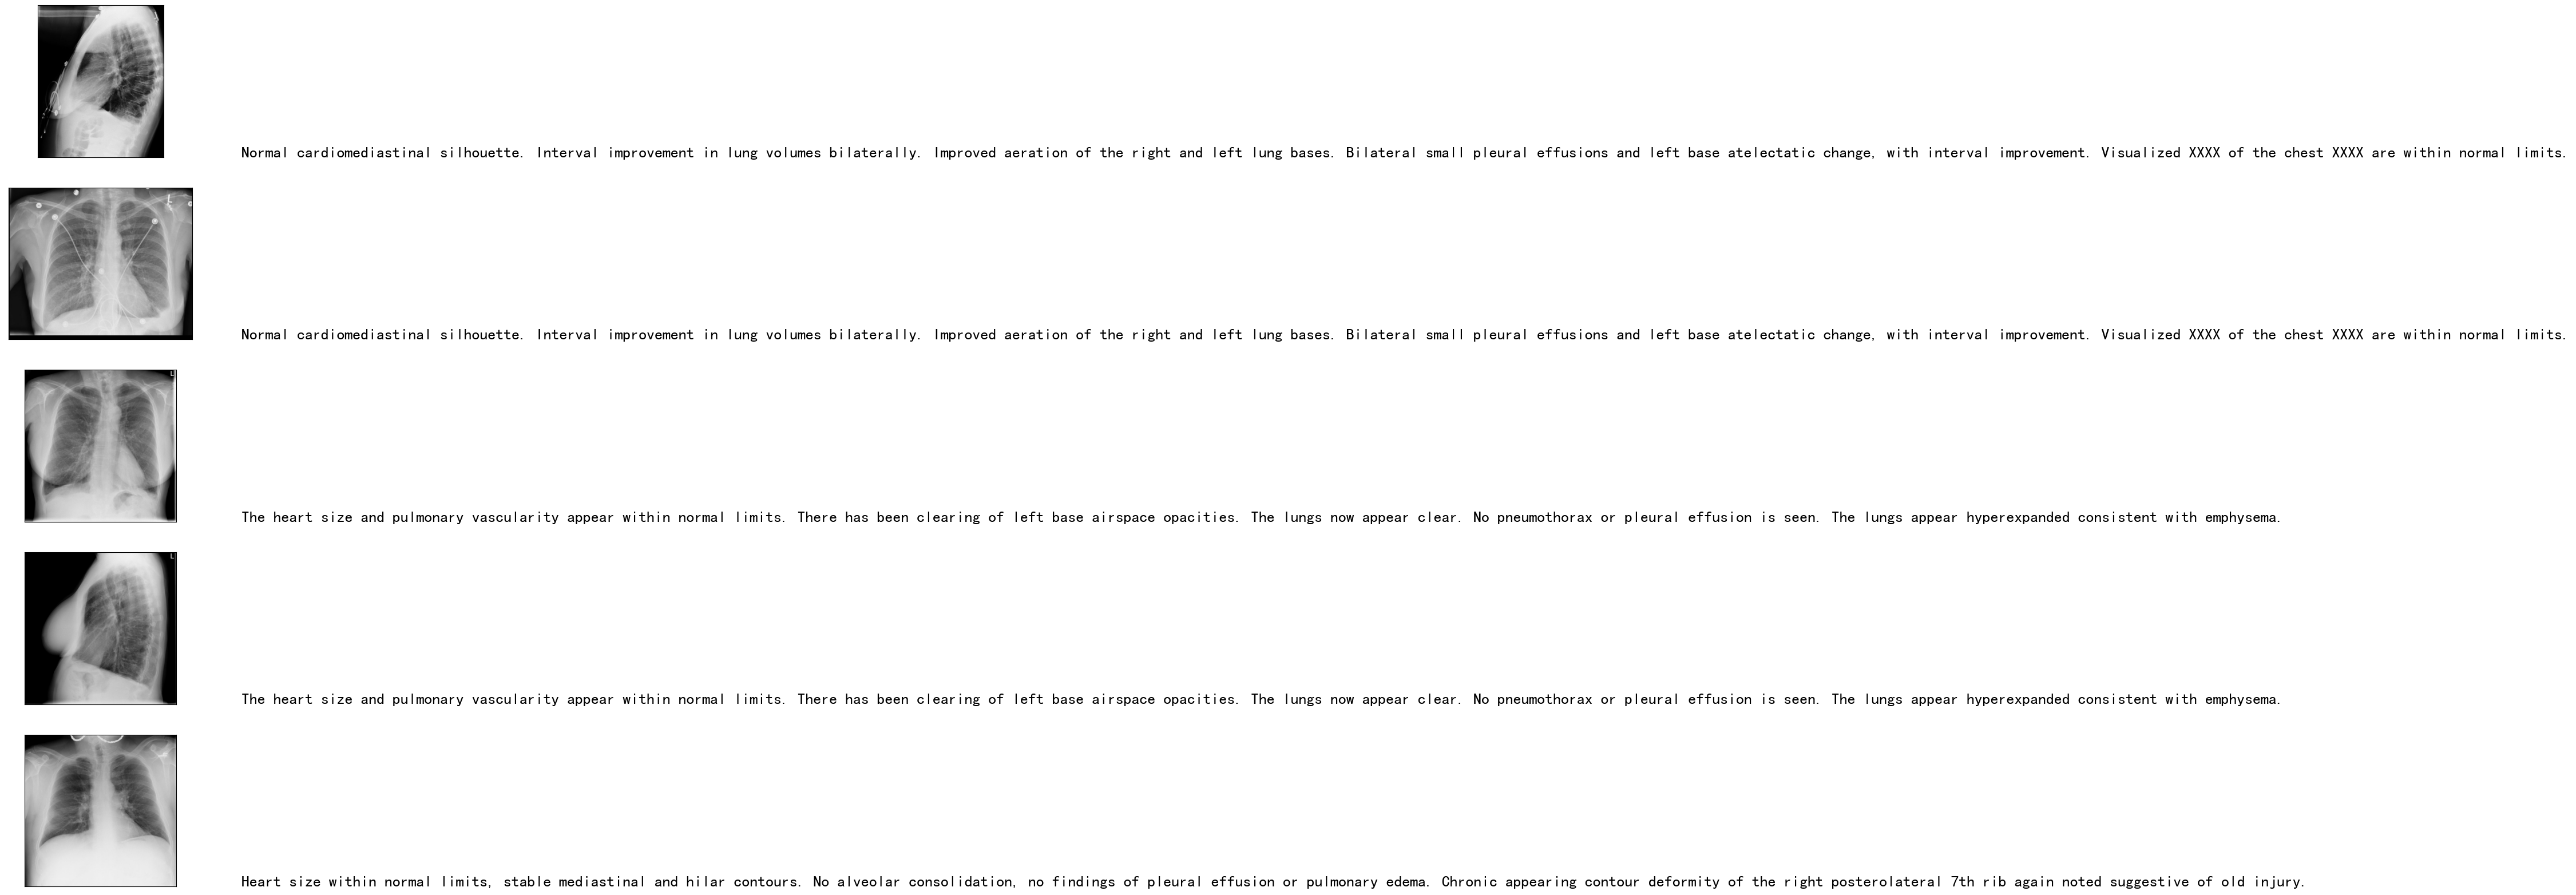

In [17]:
image_desc_plotter(dataset, 5, 'finding')

In [18]:
# loading the heights and widths of each image
h = []
w = []
for i in tqdm(np.unique(dataset['Image_path'].values)):
    img = cv2.imread(i)
    h.append(img.shape[0])
    w.append(img.shape[0])

100%|██████████████████████████████████████████████████████████████████████████████| 7470/7470 [02:57<00:00, 42.00it/s]


<AxesSubplot: title={'center': 'Width Plot'}, xlabel='--Images--', ylabel='Widths'>

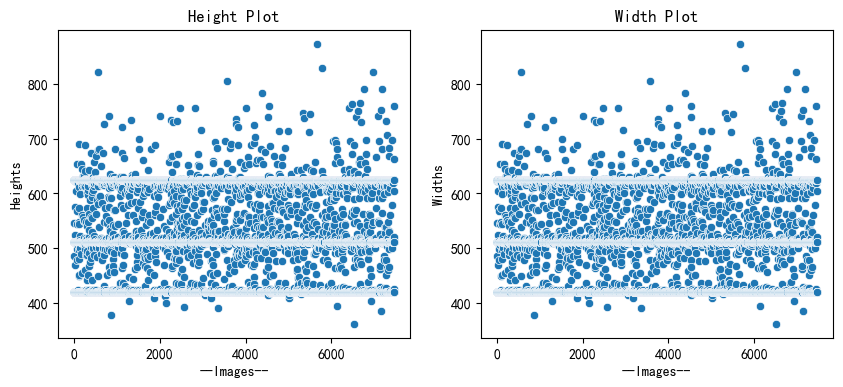

In [25]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Height Plot')
plt.ylabel('Heights')
plt.xlabel('--Images--')
sns.scatterplot(x=range(len(h)), y=h)#此处不添加xy会报错：scatterplot() takes from 0 to 1 positional arguments but 2 were given
plt.subplot(122)
plt.title('Width Plot')
plt.ylabel('Widths')
plt.xlabel('--Images--')
sns.scatterplot(x=range(len(w)), y=h)

Images have different heights and widths, they will be resized into a common shape

In [31]:
print('Number of Images:', dataset['Image_path'].nunique())

# number of missing values
print(dataset.isnull().sum())
print("There are a total of  ",dataset.isnull().sum()[1]," rows where 'findings' column has no value")

Number of Images: 7470
Image_path      0
Finding       997
dtype: int64
There are a total of   997  rows where 'findings' column has no value


In [32]:
dataset = dataset.dropna(axis=0) # drop all missing value rows

In [33]:
dataset.isnull().sum()

Image_path    0
Finding       0
dtype: int64

In [34]:
print('New Shape of the Data:', dataset.shape)

New Shape of the Data: (6473, 2)


In [35]:
dataset.head(12)

,Image_path,Finding
0,../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001-3001.png,The cardiac silhouette and mediastinum size ar...
1,../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001-4001.png,The cardiac silhouette and mediastinum size ar...
2,../data/NLMCXR/NLMCXR_png/CXR10_IM-0002-1001.png,The cardiomediastinal silhouette is within nor...
3,../data/NLMCXR/NLMCXR_png/CXR10_IM-0002-2001.png,The cardiomediastinal silhouette is within nor...
4,../data/NLMCXR/NLMCXR_png/CXR100_IM-0002-1001.png,Both lungs are clear and expanded. Heart and m...
5,../data/NLMCXR/NLMCXR_png/CXR100_IM-0002-2001.png,Both lungs are clear and expanded. Heart and m...
6,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003-1001...,There is XXXX increased opacity within the rig...
7,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003-2001...,There is XXXX increased opacity within the rig...
8,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003-3001...,There is XXXX increased opacity within the rig...
9,../data/NLMCXR/NLMCXR_png/CXR1001_IM-0004-1001...,Interstitial markings are diffusely prominent ...


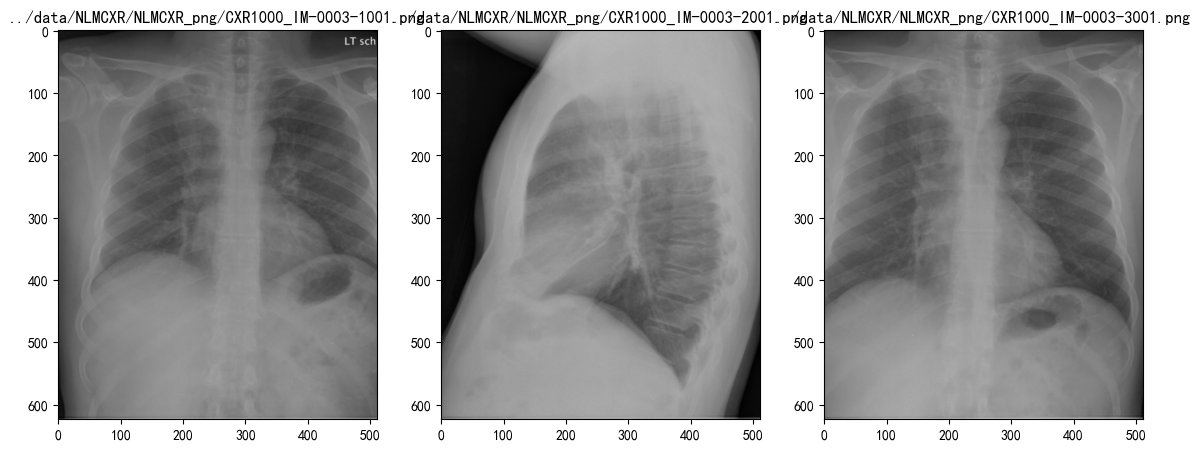

In [36]:
plt.figure(figsize=(14,7))
plt.subplot(131)
img1 = cv2.imread(dataset['Image_path'].values[6])
plt.imshow(img1)
plt.title(dataset['Image_path'].values[6])
plt.subplot(132)
img2 = cv2.imread(dataset['Image_path'].values[7])
plt.title(dataset['Image_path'].values[7])
plt.imshow(img2)
plt.subplot(133)
img3 = cv2.imread(dataset['Image_path'].values[8])
plt.title(dataset['Image_path'].values[8])
plt.imshow(img3)

In [37]:
dataset['Finding'].values[6], dataset['Finding'].values[7], dataset['Finding'].values[8]

('There is XXXX increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. The cardiac silhouette is within normal limits. XXXX opacity in the left midlung overlying the posterior left 5th rib may represent focal airspace disease. No pleural effusion or pneumothorax. No acute bone abnormality.',
 'There is XXXX increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. The cardiac silhouette is within normal limits. XXXX opacity in the left midlung overlying the posterior left 5th rib may represent focal airspace disease. No pleural effusion or pneumothorax. No acute bone abnormality.',
 'There is XXXX increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. The cardiac silhouette is within normal limits. XXXX opacity in the left midlung overlying the posterior left 5th rib may represent foca

The dataset consists of multiple chest shots of the same person. The images of a person has the same file name except the last 4 digits. Therefore that can be taken as the person ID.
该数据集由同一个人的多个胸部照片组成。一个人的图像具有相同的文件名，除了最后4位数字。因此，这可以作为人的ID。

In [38]:
# This creates 2 dictionaries with keys as the person id and the number of images and findings for that person. 
images = {}
findings = {}
for img, fin in dataset.values:
    a = img.split('-')
    a.pop(len(a)-1)
    a = '-'.join(e for e in a)
    if a not in images.keys():
        images[a] = 1
        findings[a] = fin
    else:
        images[a] += 1
        findings[a] = fin

In [44]:
images[image_dir+'CXR1001_IM-0004'], findings[image_dir+'CXR1001_IM-0004']

(2,
 'Interstitial markings are diffusely prominent throughout both lungs. Heart size is normal. Pulmonary XXXX normal.')

In [43]:
images

{'../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001': 2,
 '../data/NLMCXR/NLMCXR_png/CXR10_IM-0002': 2,
 '../data/NLMCXR/NLMCXR_png/CXR100_IM-0002': 2,
 '../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003': 3,
 '../data/NLMCXR/NLMCXR_png/CXR1001_IM-0004': 2,
 '../data/NLMCXR/NLMCXR_png/CXR1003_IM-0005': 1,
 '../data/NLMCXR/NLMCXR_png/CXR1004_IM-0005': 2,
 '../data/NLMCXR/NLMCXR_png/CXR1005_IM-0006': 2,
 '../data/NLMCXR/NLMCXR_png/CXR1006_IM-0007': 2,
 '../data/NLMCXR/NLMCXR_png/CXR1007_IM-0008': 3,
 '../data/NLMCXR/NLMCXR_png/CXR1008_IM-0009': 2,
 '../data/NLMCXR/NLMCXR_png/CXR1009_IM-0010': 2,
 '../data/NLMCXR/NLMCXR_png/CXR101_IM-0011': 2,
 '../data/NLMCXR/NLMCXR_png/CXR1010_IM-0012': 2,
 '../data/NLMCXR/NLMCXR_png/CXR1011_IM-0013': 2,
 '../data/NLMCXR/NLMCXR_png/CXR1012_IM-0013': 1,
 '../data/NLMCXR/NLMCXR_png/CXR1013_IM-0013': 2,
 '../data/NLMCXR/NLMCXR_png/CXR1015_IM-0001': 2,
 '../data/NLMCXR/NLMCXR_png/CXR1015_IM-0013': 2,
 '../data/NLMCXR/NLMCXR_png/CXR1017_IM-0013': 2,
 '../data/NLMCXR/NLMCXR_p

In [45]:
print('Total Number of Unique_IDs :', len(images.keys()))

Total Number of Unique_IDs : 3350


Text(0.5, 0, 'Number of Individuals in the Data')

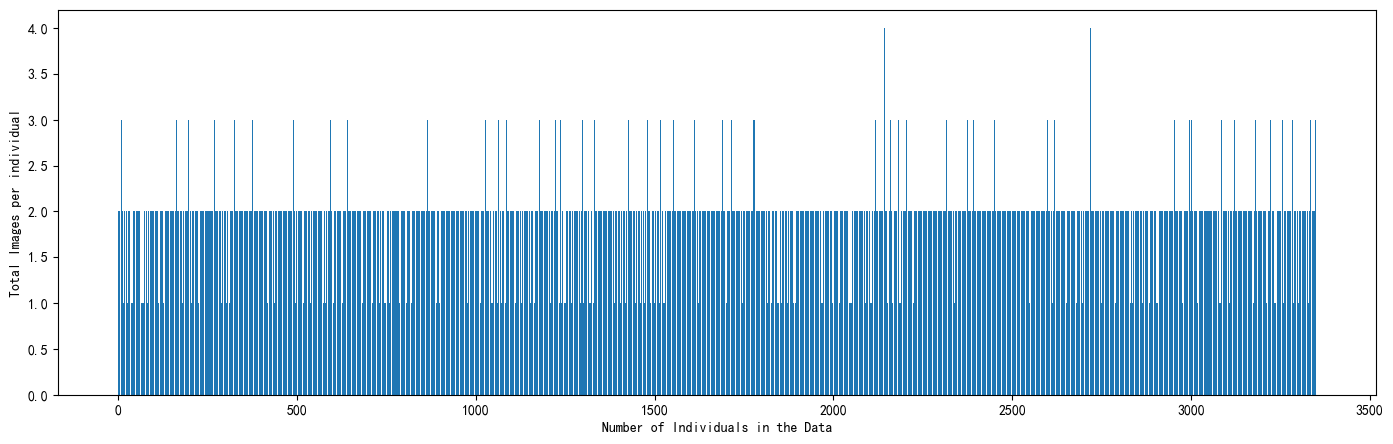

In [46]:
plt.figure(figsize=(17,5))
plt.bar(range(len(images.keys())), images.values())
plt.ylabel('Total Images per individual')
plt.xlabel('Number of Individuals in the Data')

In [48]:
one = 0
two = 0
three = 0
four = 0
for v in images.values():
    if v == 1:
        one +=1
    elif v == 2:
        two += 1
    elif v == 3:
        three += 1
    elif v == 4:
        four += 1
    else:
        print('Error')
one, two, three, four

(390, 2807, 143, 10)

The above variables one, two, three, four contains the total number of IDs with 1,2,3,4 number of images respectively.

As we can see there are multiple images corresponding to a single person. These are different chest scans at different views. Most of the individuals have only 2 scans while the highest being 4.

In [49]:
#len(images)
def train_test_split(data):
    persons = list(data.keys())
    persons_train = persons[:2500]
    persons_cv = persons[2500:3000]
    persons_test = persons[3000:3350]
    return persons_train, persons_cv, persons_test

In [50]:
images_train, images_cv, images_test = train_test_split(images)

In [55]:
def combining_images(image_set):
    
    image_per_person = defaultdict(list)  # creating a list of dictionary to store all the image paths
                                            #corresponding to a person_id
    for pid in image_set:
        for img in dataset['Image_path'].values:
            if pid in img:
                image_per_person[pid].append(img)
            else:
                continue
    return image_per_person

In [56]:
img_per_person_train = combining_images(images_train)
img_per_person_cv = combining_images(images_cv)
img_per_person_test = combining_images(images_test)

In [57]:
len(img_per_person_train), len(images_train)

(2500, 2500)

In [58]:
img_per_person_train[image_dir+'CXR1001_IM-0004']

['../data/NLMCXR/NLMCXR_png/CXR1001_IM-0004-1001.png',
 '../data/NLMCXR/NLMCXR_png/CXR1001_IM-0004-1002.png']

In [59]:
# def load_image(file):
#     img = tf.io.read_file(file)
#     img = tf.image.decode_png(img, channels=3)
#     img = tf.image.convert_image_dtype(img, tf.float32)
#     return img

In [60]:
# just checking the ID which has 4 images
for k,v in images.items():
    if v == 4:
        print(k)
        break

../data/NLMCXR/NLMCXR_png/CXR1102_IM-0069


NameError: name 'tf' is not defined

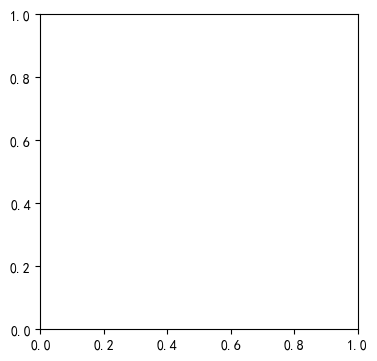

In [61]:
# plt.figure(figsize=(9,9))
# plt.subplot(221)
# plt.imshow(load_image('Scanned Images/CXR1102_IM-0069-12012.png'))
# plt.title('Scanned Images/CXR1102_IM-0069-12012.png')
# plt.subplot(222)
# plt.imshow(load_image('Scanned Images/CXR1102_IM-0069-2001.png'))
# plt.title('Scanned Images/CXR1102_IM-0069-2001.png')
# plt.subplot(223)
# plt.imshow(load_image('Scanned Images/CXR1102_IM-0069-3001.png'))
# plt.title('Scanned Images/CXR1102_IM-0069-3001.png')
# plt.subplot(224)
# plt.imshow(load_image('Scanned Images/CXR1102_IM-0069-4004.png'))
# plt.title('Scanned Images/CXR1102_IM-0069-4004.png')

2 side view and 2 front view images for the same ID

Sample chest scans of a person(4 images)

Now, we have multiple chest scans to produce a single report. Some person_ids have 1, some have 2 and the highest is 4. So we can take pairs of those images as input. If it has only one image, then it can be replicated.

In [62]:
def create_data(image_per_person):
    # new dataset
    person_id, image1, image2, report = [],[],[],[]
    for pid, imgs in image_per_person.items():   #contains pid and the images associated with that pid

        if len(imgs) == 1:
            image1.append(imgs[0])
            image2.append(imgs[0])
            person_id.append(pid)
            report.append(findings[pid])
        else:
            num = 0
            a = itertools.combinations(imgs, 2)
            for i in a:
                image1.append(i[0])
                image2.append(i[1])
                person_id.append(pid + '_' + str(num))
                report.append(findings[pid])
                num += 1
    data = pd.DataFrame()
    data['Person_id'] = person_id
    data['Image1'] = image1
    data['Image2'] = image2
    data['Report'] = report
    
    return data

In [65]:
train = create_data(img_per_person_train)
test = create_data(img_per_person_test)
cv = create_data(img_per_person_cv)

In [66]:
train.head()

,Person_id,Image1,Image2,Report
0,../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001_0,../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001-3001.png,../data/NLMCXR/NLMCXR_png/CXR1_1_IM-0001-4001.png,The cardiac silhouette and mediastinum size ar...
1,../data/NLMCXR/NLMCXR_png/CXR10_IM-0002_0,../data/NLMCXR/NLMCXR_png/CXR10_IM-0002-1001.png,../data/NLMCXR/NLMCXR_png/CXR10_IM-0002-2001.png,The cardiomediastinal silhouette is within nor...
2,../data/NLMCXR/NLMCXR_png/CXR100_IM-0002_0,../data/NLMCXR/NLMCXR_png/CXR100_IM-0002-1001.png,../data/NLMCXR/NLMCXR_png/CXR100_IM-0002-2001.png,Both lungs are clear and expanded. Heart and m...
3,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003_0,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003-1001...,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003-2001...,There is XXXX increased opacity within the rig...
4,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003_1,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003-1001...,../data/NLMCXR/NLMCXR_png/CXR1000_IM-0003-3001...,There is XXXX increased opacity within the rig...


# Text Cleaning

In [67]:
def lowercase(text):
    '''Converts to lowercase'''
    new_text = []
    for line in text:
        new_text.append(line.lower())
    return new_text

def decontractions(text):
    '''Performs decontractions in the doc'''
    new_text = []
    for phrase in text:
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        phrase = re.sub(r"couldn\'t", "could not", phrase)
        phrase = re.sub(r"shouldn\'t", "should not", phrase)
        phrase = re.sub(r"wouldn\'t", "would not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        phrase = re.sub(r"\*+", "abuse", phrase)
        new_text.append(phrase)

    return new_text

def rem_punctuations(text):
    '''Removes punctuations'''
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*~''' # full stop is not removed
    new_text = []
    for line in text:
        for char in line:
            if char in punctuations: 
                line = line.replace(char, "")
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def rem_numbers(text):
    '''Removes numbers and irrelevant text like xxxx*'''
    new_text = []
    for line in text:
        temp = re.sub(r'x*','',line)
        new_text.append(re.sub(r'\d','',temp))
    return new_text

def words_filter(text):
    '''Removes words less than 2 characters except no and ct'''
    new_text = []
    for line in text:
        temp = line.split()
        temp2 = []
        for word in temp:
            if  len(word) <=2 and word != 'no' and word != 'ct':
                continue
            else:
                temp2.append(word)
        new_text.append(' '.join(e for e in temp2))
    return new_text

def multiple_fullstops(text):
    ''' Removes multiple full stops from the text'''
    new_text = []
    for line in text:
        new_text.append(re.sub(r'\.\.+', '.', line))
    return new_text

def fullstops(text):
    new_text = []
    for line in text:
        new_text.append(re.sub('\.', ' .', line))
    return new_text

def multiple_spaces(text):
    new_text = []
    for line in text:
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def separting_startg_words(text):
    new_text = []
    for line in text:
        temp = []
        words = line.split()
        for i in words:
            if i.startswith('.') == False:
                temp.append(i)
            else:
                w = i.replace('.','. ')
                temp.append(w)
        new_text.append(' '.join(e for e in temp))
    return new_text

def rem_apostrophes(text):
    new_text = []
    for line in text:
        new_text.append(re.sub("'",'',line))
    return new_text

In [68]:
def text_preprocessing(text):
    '''Combines all the preprocess functions'''
    new_text = lowercase(text)
    new_text = decontractions(new_text)
    new_text = rem_punctuations(new_text)
    new_text = rem_numbers(new_text)
    new_text = words_filter(new_text)
    new_text = multiple_fullstops(new_text)
    new_text = fullstops(new_text)
    new_text = multiple_spaces(new_text)
    new_text = separting_startg_words(new_text)
    new_text = rem_apostrophes(new_text)
    return new_text

In [71]:
train['Report'] = text_preprocessing(train['Report'])
test['Report'] = text_preprocessing(test['Report'])
cv['Report'] = text_preprocessing(cv['Report'])

In [72]:
length = [len(e.split()) for e in train['Report'].values]# Number of words in each report
max(length)

153

Text(0, 0.5, 'Number of words')

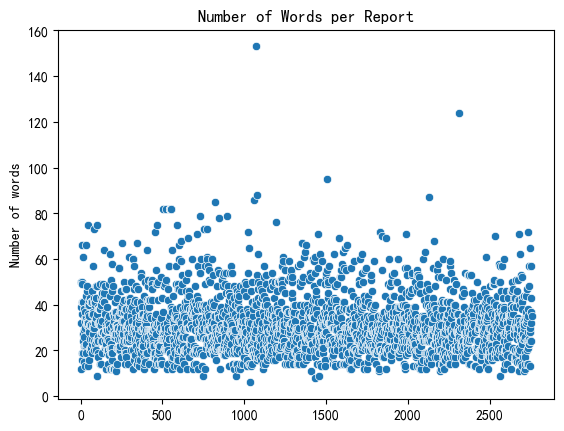

In [74]:
plt.title('Number of Words per Report')
sns.scatterplot(x=range(train.shape[0]), y=length)
plt.ylabel('Number of words')

In [76]:
l = []
for i in train['Report'].values:
    l.extend(i.split())

c = Counter(l)

In [77]:
words = []
count = []
for k,v in c.items():
    words.append(k)
    count.append(v)
words_count = list(zip(count, words))

In [78]:
top_50_words = sorted(words_count)[::-1][:50]
bottom_50_words = sorted(words_count)[:50]

([<matplotlib.axis.XTick at 0x251b46f1190>,
 [Text(0, 0, '.'),
  Text(1, 0, 'the'),
  Text(2, 0, 'no'),
  Text(3, 0, 'are'),
  Text(4, 0, 'normal'),
  Text(5, 0, 'and'),
  Text(6, 0, 'pleural'),
  Text(7, 0, 'there'),
  Text(8, 0, 'pneumothora'),
  Text(9, 0, 'effusion'),
  Text(10, 0, 'heart'),
  Text(11, 0, 'lungs'),
  Text(12, 0, 'size'),
  Text(13, 0, 'focal'),
  Text(14, 0, 'within'),
  Text(15, 0, 'clear'),
  Text(16, 0, 'limits'),
  Text(17, 0, 'pulmonary'),
  Text(18, 0, 'consolidation'),
  Text(19, 0, 'silhouette'),
  Text(20, 0, 'right'),
  Text(21, 0, 'mediastinal'),
  Text(22, 0, 'airspace'),
  Text(23, 0, 'cardiomediastinal'),
  Text(24, 0, 'left'),
  Text(25, 0, 'acute'),
  Text(26, 0, 'lung'),
  Text(27, 0, 'with'),
  Text(28, 0, 'unremarkable'),
  Text(29, 0, 'disease'),
  Text(30, 0, 'stable'),
  Text(31, 0, 'spine'),
  Text(32, 0, 'mediastinum'),
  Text(33, 0, 'structures'),
  Text(34, 0, 'changes'),
  Text(35, 0, 'contours'),
  Text(36, 0, 'thoracic'),
  Text(37, 0, 

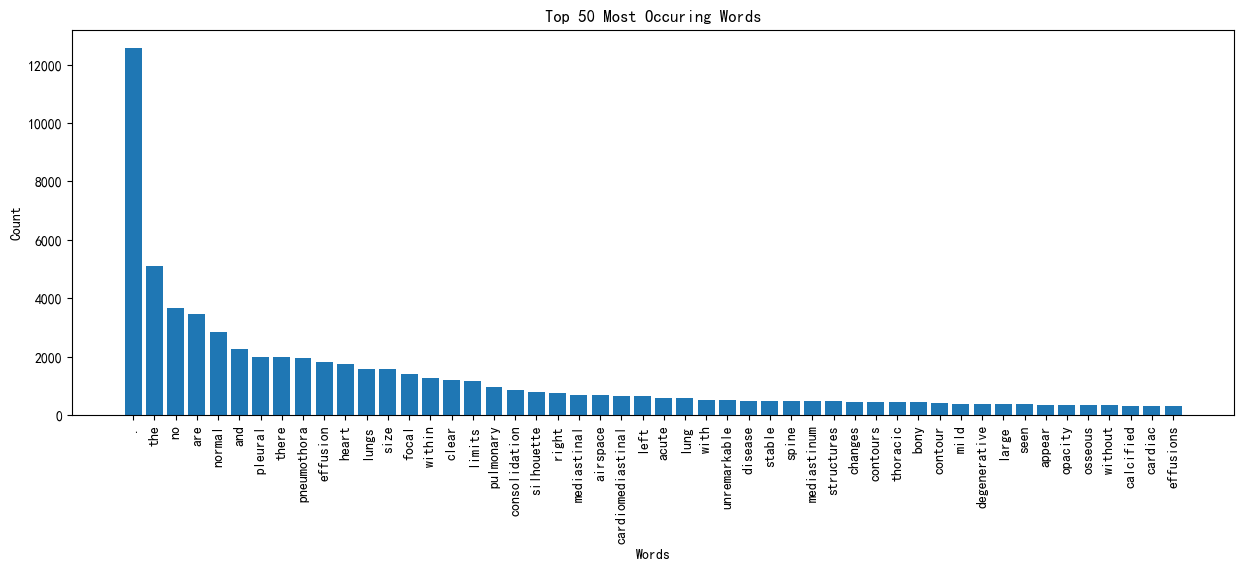

In [79]:
plt.figure(figsize=(15,5))
plt.bar(range(50), [c for c,w in top_50_words])
plt.title('Top 50 Most Occuring Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(ticks=range(50), labels=[w for c,w in top_50_words], rotation=90)

([<matplotlib.axis.XTick at 0x251b4a1db50>,
 [Text(0, 0, 'abut'),
  Text(1, 0, 'accentuates'),
  Text(2, 0, 'accessed'),
  Text(3, 0, 'accessory'),
  Text(4, 0, 'activeacute'),
  Text(5, 0, 'acuity'),
  Text(6, 0, 'after'),
  Text(7, 0, 'airfluid'),
  Text(8, 0, 'all'),
  Text(9, 0, 'already'),
  Text(10, 0, 'although'),
  Text(11, 0, 'aneurysm'),
  Text(12, 0, 'angulate'),
  Text(13, 0, 'annular'),
  Text(14, 0, 'anteriorly'),
  Text(15, 0, 'anterolateral'),
  Text(16, 0, 'aorticopulmonary'),
  Text(17, 0, 'appreciable'),
  Text(18, 0, 'appropriate'),
  Text(19, 0, 'arterial'),
  Text(20, 0, 'arthroplasty'),
  Text(21, 0, 'articular'),
  Text(22, 0, 'artifactually'),
  Text(23, 0, 'asbestos'),
  Text(24, 0, 'aside'),
  Text(25, 0, 'aspiration'),
  Text(26, 0, 'assessment'),
  Text(27, 0, 'atelectaticfibrotic'),
  Text(28, 0, 'atriumcavoatrial'),
  Text(29, 0, 'attached'),
  Text(30, 0, 'avn'),
  Text(31, 0, 'balloon'),
  Text(32, 0, 'believed'),
  Text(33, 0, 'benefit'),
  Text(34, 0,

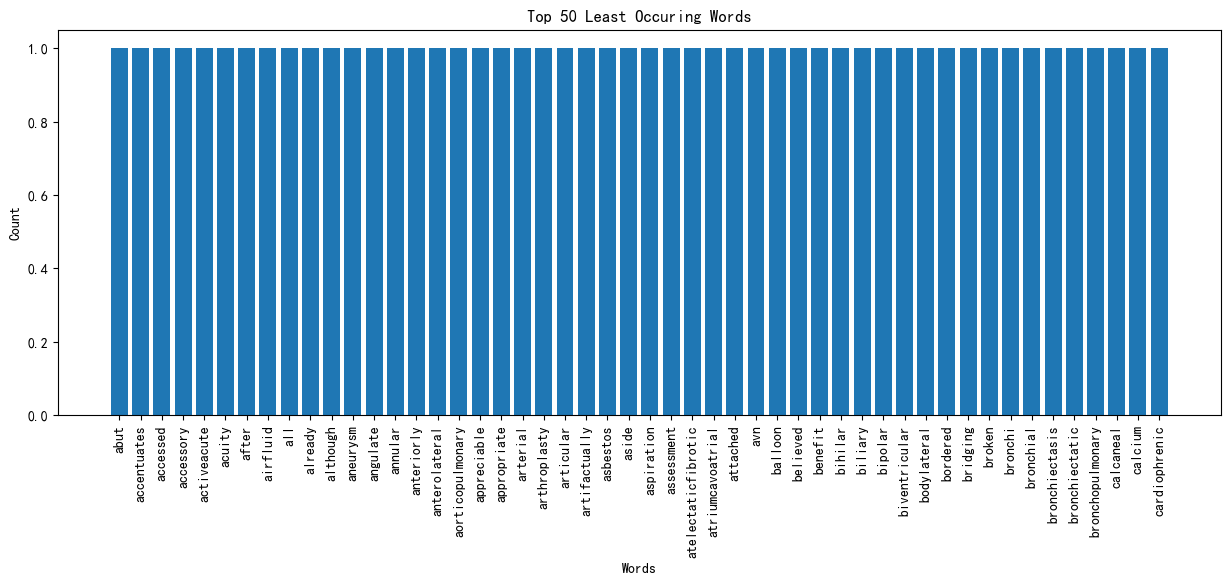

In [80]:
plt.figure(figsize=(15,5))
plt.bar(range(50), [c for c,w in bottom_50_words])
plt.title('Top 50 Least Occuring Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(ticks=range(50), labels=[w for c,w in bottom_50_words], rotation=90)

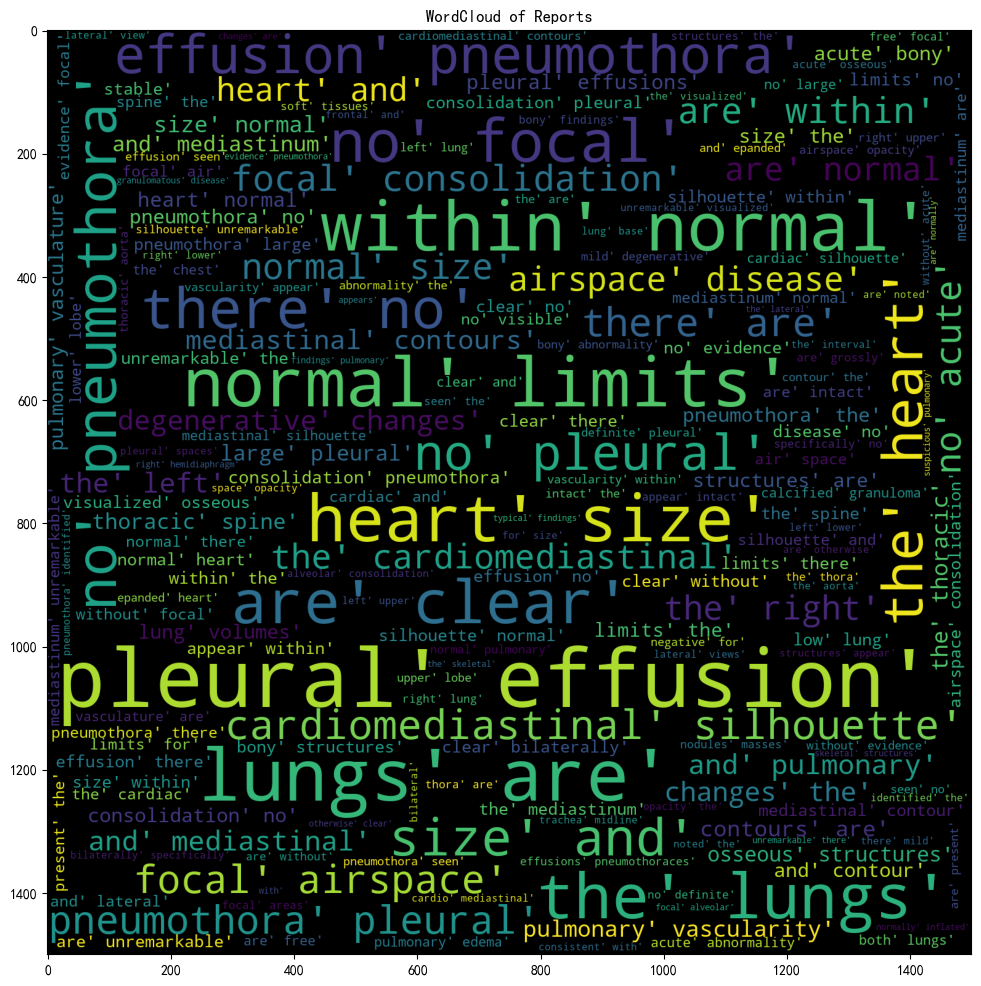

In [85]:
w = WordCloud(height=1500, width=1500).generate(str(l))

plt.figure(figsize=(12,12))
plt.title('WordCloud of Reports')
plt.imshow(w)

In [86]:
def remodelling(x):
    '''adds start and end tokens to a sentence '''
    return 'startseq' + ' ' + x + ' ' + 'endseq'

In [87]:
train['Report'] = train['Report'].apply(lambda x : remodelling(x))
test['Report'] = test['Report'].apply(lambda x : remodelling(x))
cv['Report'] = cv['Report'].apply(lambda x : remodelling(x))

In [88]:
# save the cleaned data(STRUCTURED DATA)
train.to_csv('Train_Data.csv', index=False)
test.to_csv('Test_Data.csv', index=False)
cv.to_csv('CV_Data.csv', index=False)